# 6. 합성곱 신경망
## 6.2 AlexNet

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
#images, labels = iter(trainloader).next()
#print(images.size()) # 배치 및 이미지 크기 확인

In [22]:
#def imshow(img):
    # img = .5*img + .5
    # plt.figure(figsize=(10,100))
    # plt.imshow(img.permute(1,2,0).numpy())
    # plt.show()



In [23]:
#imshow(torchvision.utils.make_grid(images,nrow=8))

In [24]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [25]:
# Conv→ReLU→MaxPool→ Conv→ReLU→MaxPool→Conv→ReLU→ Conv→ReLU→Conv→ReLU→MaxPool→FC1→ReLU→FC2→ReLU→FC3

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 1), nn.ReLU(),
                        nn.MaxPool2d(2, 2)
                        )

        self.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256*3*3, 1024), nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1024, 512), nn.ReLU(),
                        nn.Linear(512, 10)
                        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)
        return x

alexnet = AlexNet().to(device) # 모델 선언


In [26]:
print(alexnet)
PATH = './models/cifar_alexnet.pth' # 모델 저장 경로

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Lin

In [27]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [29]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

        optimizer.zero_grad()
        outputs = alexnet(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

[1] loss: 1.035
[2] loss: 0.892
[3] loss: 0.788
[4] loss: 0.712
[5] loss: 0.660
[6] loss: 0.609
[7] loss: 0.571
[8] loss: 0.539
[9] loss: 0.500
[10] loss: 0.483


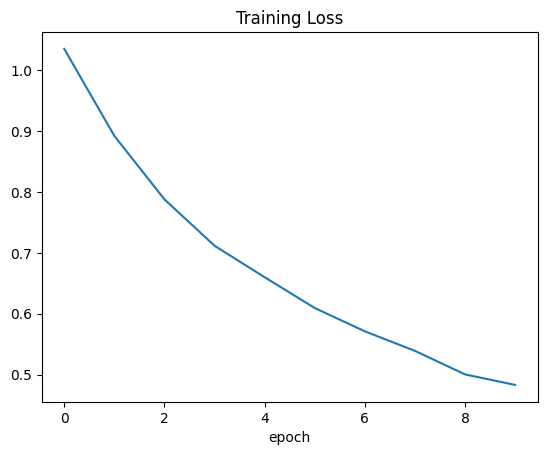

In [30]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.4 모델 저장하기

In [31]:
torch.save(alexnet.state_dict(), PATH) # 모델 저장

## 5.5 모델 불러오기

In [32]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다. 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

alexnet = AlexNet().to(device) # 모델 선언
alexnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

## 5.6 모델 정확도(Accuracy) 구하기

In [33]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    alexnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

Test accuracy: 75.21 %
